R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/Diagnostics_for_multiple_regression.html


NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

## Diagnostics in multiple linear regression - Part 1
(The original document has part 1 and part 2 together)

### Outline

-   Diagnostics â€“ again

-   Different types of residuals

-   Influence

-   Outlier detection

-   Residual plots:

    -   partial regression (added variable) plot,

    -   partial residual (residual plus component) plot.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
sm.version.version

'0.9.0'

## Scottish hill races data

The dataset we will use is based on record times on [Scottish hill races](http://www.statsci.org/data/general/hills.html).

<table>
<tr><td><b>Variable</b></td><td><b>Description</b></td></tr>
<tr><td>Time</td><td>Record time to complete course</td></tr>
<tr><td>Distance</td><td>Distance in the course</td></tr>
<tr><td>Climb</td><td>Vertical climb in the course</td></tr>
</table>


In [3]:
url = "http://www.statsci.org/data/general/hills.txt"

In [4]:
data = pd.read_table(url, header=[0], index_col=0)
data.head()

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


,Distance,Climb,Time
Race,,,
Greenmantle,2.5,650,16.083
Carnethy,6.0,2500,48.350
CraigDunain,6.0,900,33.650
BenRha,7.5,800,45.600
BenLomond,8.0,3070,62.267


In [5]:
data.columns

Index(['Distance', 'Climb', 'Time'], dtype='object')

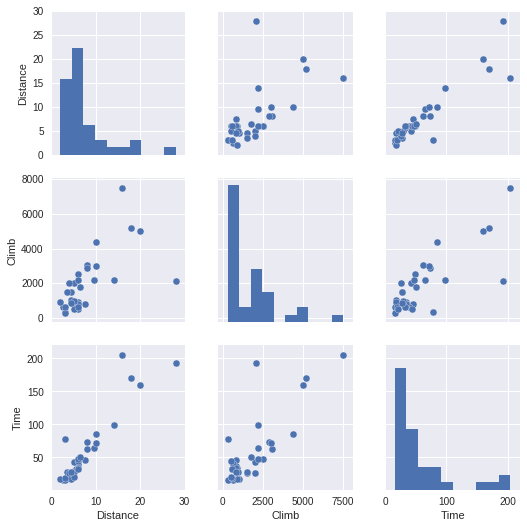

In [6]:
sns.pairplot(data)
plt.show()

In [7]:
formula = 'Time ~ Distance + Climb'

In [8]:
res = ols(formula, data=data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     181.7
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           3.40e-18
Time:                        01:06:11   Log-Likelihood:                -142.11
No. Observations:                  35   AIC:                             290.2
Df Residuals:                      32   BIC:                             294.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.9920      4.303     -2.090      0.045     -17.756      -0.228
Distance       6.2180      0.601     10.343      0.000       4.993       7.442
Climb          0.0110      0.002      5.387      0.000       0.007       0.015
==============================================================================
Omnibus:                       47.910   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.976
Skew:                           3.026   Prob(JB):                     1.56e-51
Kurtosis:                      14.127   Cond. No.                     4.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

But is this a good model? 

## Diagnostics

### What can go wrong?

-   Regression function can be wrong: maybe regression function should
    have some other form (see diagnostics for simple linear regression).

-   Model for the errors may be incorrect:

    -   may not be normally distributed.

    -   may not be independent.

    -   may not have the same variance.

-   Detecting problems is more *art* then *science*, i.e. we cannot
    *test* for all possible problems in a regression model.

## Diagnostics

-   Basic idea of diagnostic measures: if model is correct then
    residuals $e_i = Y_i -\widehat{Y}_i, 1 \leq i \leq n$ should look
    like a sample of (not quite independent) $N(0, \sigma^2)$ random
    variables.

## Standard diagnostic plots

`R` produces a set of standard plots for `lm` that help us assess whether our assumptions are reasonable or not. We will go through each in some, but not too much, detail.

As we see below, there are some quantities which we need to define in order to read these plots. We will define these first.

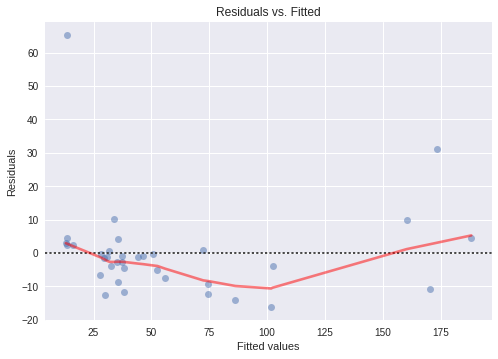

In [9]:
# Residuals vs. Fitted
# with a 'locally weighted scatterplot smoothing (lowess)' regression line 
sns.residplot(res.fittedvalues, 'Time', data=data, lowess=True,
             scatter_kws={'alpha': 0.5},
             line_kws={'color': 'red', 'alpha':0.5})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

"This plot shows if residuals have non-linear patterns. There could be a non-linear relationship between predictor variables and an outcome variable and the pattern could show up in this plot if the model doesn’t capture the non-linear relationship. If you find equally spread residuals around a horizontal line without distinct patterns, that is a good indication you don’t have non-linear relationships."

"...the non-linear relationship was not explained by the model and was left out in the residuals"


Source: https://data.library.virginia.edu/diagnostic-plots/

In [10]:
# linearity test
# Harvey-Collier multiplier test
# The Null hypothesis is that the regression is correctly modeled as linear.
# If the true relationship is not linear but convex or concave 
# the mean of the recursive residuals should differ from 0 significantly.
linear_harvey_collier(res)
# Source: https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.linear_harvey_collier.html
# Source: http://math.furman.edu/~dcs/courses/math47/R/library/lmtest/html/harvtest.html

Ttest_1sampResult(statistic=0.04986993379169385, pvalue=0.9605459765440796)

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


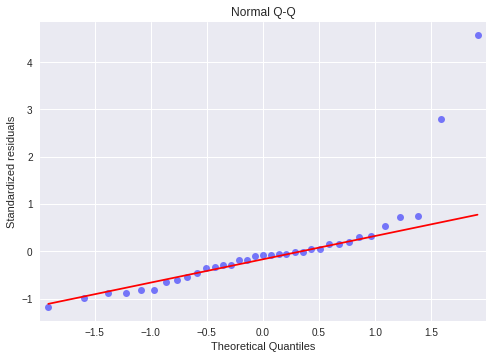

In [11]:
# Normal Q-Q Plot
# how well the distribution of resid fit the normal distribution
# the standardized residuals vs. normal quantiles
# Normal Q-Q Plot

# result.resid also works too
# qplot(res.resid, line='q', alpha=0.5)
# standardized residuals
qqplot(res.get_influence().resid_studentized_internal, line='q', alpha=0.5)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized residuals')
plt.title('Normal Q-Q')
plt.show()

"Do residuals follow a straight line well or do they deviate severely? It’s good if residuals are lined well..."

Source: https://data.library.virginia.edu/diagnostic-plots/

[ 0.16454678 -0.53015742 -0.32025768 -0.06153956 -0.86942853  0.0559802
  2.79819456 -0.05476367 -0.08249712  0.29667307  0.53290726 -0.07967326
 -0.65001853  0.72009604 -0.59963166 -0.9815245  -0.2809337   4.56558067
 -0.87696131  0.05103257  0.20862403 -0.10076608 -0.34686042  0.31923417
  0.16732023 -0.82422465 -0.18933769 -0.27965703 -0.01788515 -0.46599435
 -1.17891252 -0.17883396  0.73890152 -0.01944034 -0.81619003]
[0.40564366 0.7281191  0.56591314 0.24807167 0.93243151 0.23660134
 1.67278049 0.23401638 0.28722312 0.54467703 0.73000497 0.28226453
 0.80623727 0.84858473 0.77435887 0.99071919 0.53003179 2.13672195
 0.93646212 0.2259039  0.4567538  0.31743673 0.58894858 0.56500812
 0.40904796 0.90786819 0.43512951 0.52882608 0.13373537 0.68263779
 1.08577738 0.42288765 0.85959381 0.13942863 0.90343236]


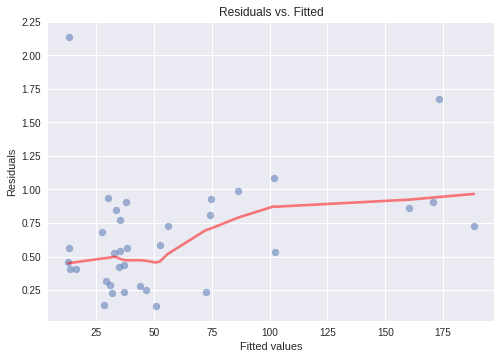

In [12]:
# Scale-location
# abs sqrt(Standardized residuals) vs. Fitted values
norm_resid = res.get_influence().resid_studentized_internal
print(norm_resid)
abs_sqrt_norm_resid = np.sqrt(np.abs(norm_resid))
print(abs_sqrt_norm_resid)
plt.scatter(res.fittedvalues, abs_sqrt_norm_resid, alpha=0.5)
sns.regplot(res.fittedvalues, abs_sqrt_norm_resid, scatter=False, ci=False, lowess=True,
             line_kws={'color': 'red', 'alpha':0.5})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

"It’s also called Spread-Location plot. This plot shows if residuals are spread equally along the ranges of predictors. This is how you can check the assumption of equal variance (homoscedasticity). It’s good if you see a horizontal line with equally (randomly) spread points."

"...(if) the residuals spread wider and wider, the red smooth line is not horizontal and shows a steep angle"

Source: https://data.library.virginia.edu/diagnostic-plots/

The following tests differ in which kind of heteroscedasticity is considered as alternative hypothesis. They also vary in the power of the test for different types of heteroscedasticity.
* Breusch-Pagan
* White
* goldfeld-quandt

Source: http://www.statsmodels.org/stable/diagnostic.html

In [13]:
# equal variance test
# Breusch-Pagan Lagrange Multiplier test for heteroscedasticity
# The null hypothesis is that all observations have the same error variance, 
# i.e. errors are homoscedastic.
# Small p-value shows that there is violation of homoscedasticity.

test_res = het_breuschpagan(res.resid, exog_het=res.model.exog)
print("lagrange multiplier statistic      : ", test_res[0])
print("p-value of lagrange multiplier test: ", test_res[1])
# f-statistic of the hypothesis that the error variance does not depend on x 
print("f-statistic                        : ", test_res[2])
print("p-value for the f-statistic        : ", test_res[3])
# Source: https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.het_breuschpagan.html

lagrange multiplier statistic      :  0.3639464134894793
p-value of lagrange multiplier test:  0.8336236756084493
f-statistic                        :  0.16812373272512757
p-value for the f-statistic        :  0.845990987634143


In [14]:
# equal variance test
# White Lagrange Multiplier test for heteroscedasticity

test_res = het_white(res.resid, exog=res.model.exog)
print("lagrange multiplier statistic      : ", test_res[0])
print("p-value of lagrange multiplier test: ", test_res[1])
# f-statistic of the hypothesis that the error variance does not depend on x. 
# This is an alternative test variant not the original LM test.
print("f-statistic                        : ", test_res[2])
print("p-value for the f-statistic        : ", test_res[3])
# Source: https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_white.html

lagrange multiplier statistic      :  3.8281398362316397
p-value of lagrange multiplier test:  0.5744155112840938
f-statistic                        :  0.7122838012712094
p-value for the f-statistic        :  0.6191728280782418


In [15]:
# equal variance test
# Goldfeld-Quandt test for heteroscedasticity

name = ['F statistic', 'p-value']
test = het_goldfeldquandt(res.resid, res.model.exog)
lzip(name, test)
# Source: https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html

[('F statistic', 3.2700075922870013), ('p-value', 0.0147557097917041)]

[0.05375572 0.04946414 0.03840444 0.04848872 0.05527121 0.04680469
 0.42043463 0.04103328 0.04025783 0.04570891 0.68981613 0.04345357
 0.03231875 0.05126338 0.03877135 0.04436257 0.08313942 0.05535523
 0.03850209 0.04590867 0.05657466 0.0482578  0.03977381 0.05842537
 0.05072281 0.05499644 0.04103328 0.03758135 0.02992818 0.04824732
 0.12158212 0.04746275 0.17158482 0.04032547 0.19098908]


/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide


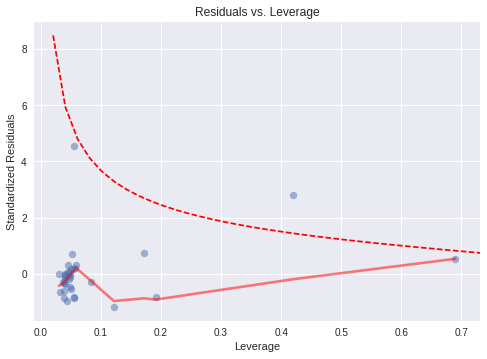

In [16]:
# Residuals vs. Leverage
# See whether an outlier has influence. 
norm_resid = res.get_influence().resid_studentized_internal
leverage = res.get_influence().hat_matrix_diag
print(leverage)
plt.scatter(leverage, norm_resid, alpha=0.5)
sns.regplot(leverage, norm_resid, scatter=False, ci=False, lowess=True,
             line_kws={'color': 'red', 'alpha':0.5})
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs. Leverage')

x = np.linspace(0, 1, 50)
y = np.sqrt((0.5 * len(res.params) * (1 - x)) / x)
plt.plot(x, y, label='Cook\'s distance', ls='--', color='red')
plt.show()

"This plot helps us to find influential cases (i.e., subjects) if any. Not all outliers are influential in linear regression analysis (whatever outliers mean). Even though data have extreme values, they might not be influential to determine a regression line. That means, the results wouldn’t be much different if we either include or exclude them from analysis. They follow the trend in the majority of cases and they don’t really matter; they are not influential. On the other hand, some cases could be very influential even if they look to be within a reasonable range of the values. They could be extreme cases against a regression line and can alter the results if we exclude them from analysis. Another way to put it is that they don’t get along with the trend in the majority of the cases."

"Unlike the other plots, this time patterns are not relevant. We watch out for outlying values at the upper right corner or at the lower right corner. Those spots are the places where cases can be influential against a regression line. Look for cases outside of a dashed line, Cook’s distance. When cases are outside of the Cook’s distance (meaning they have high Cook’s distance scores), the cases are influential to the regression results. The regression results will be altered if we exclude those cases."

"a case is far beyond the Cook’s distance lines.."

Source: https://data.library.virginia.edu/diagnostic-plots/

In [17]:
# Residuals vs. Fitted
def residuals_fitted(data, y, result, ax):
    sns.residplot(result.fittedvalues, y, 
                  data=data, 
                  lowess=True,
                  scatter_kws={'alpha': 0.5},
                  line_kws={'color': 'red', 'alpha':0.5},
                  ax=ax)
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    ax.set_title('Residuals vs. Fitted')
    return ax

In [18]:
# Normal Q-Q Plot
def normal_qq_plot(result, ax):
    # result.resid also works too
#     fig = qqplot(result.resid, line='q', alpha=0.5, ax=ax)
    # standardized residuals
    fig = qqplot(result.get_influence().resid_studentized_internal, line='q', alpha=0.5, ax=ax)
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Standardized residuals')
    ax.set_title('Normal Q-Q')
    return fig

In [19]:
# Scale-location
def scale_location(result, ax):
    norm_resid = result.get_influence().resid_studentized_internal
    abs_sqrt_norm_resid = np.sqrt(np.abs(norm_resid))
    ax.scatter(result.fittedvalues, abs_sqrt_norm_resid, alpha=0.5)
    sns.regplot(result.fittedvalues, abs_sqrt_norm_resid, 
                scatter=False, ci=False, lowess=True,
                line_kws={'color': 'red', 'alpha':0.5},
                ax=ax)
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('np.sqrt(standardized residuals)')
    ax.set_title('Scale-location')
    return ax

In [20]:
# Residuals vs. Leverage
def residuals_leverage(result, ax): 
    norm_resid = result.get_influence().resid_studentized_internal
    leverage = result.get_influence().hat_matrix_diag
    ax.scatter(leverage, norm_resid, alpha=0.5)
    sns.regplot(leverage, norm_resid, 
                scatter=False, ci=False, lowess=True,
                line_kws={'color': 'red', 'alpha':0.5},
                ax=ax)
    ax.set_xlabel('Leverage')
    ax.set_ylabel('Standardized Residuals')
    ax.set_title('Residuals vs. Leverage')

    x = np.linspace(0, 1, 50)
    y = np.sqrt((0.5 * len(result.params) * (1 - x)) / x)
    ax.plot(x, y, label='Cook\'s distance', ls='--', color='red')
    ax.set_xlim([0, 1])
    return ax

In [21]:
def make_plots(data, y, result):
    fig, axes = plt.subplots(2,2, sharex=False, sharey=False)
    axes[0, 0] = residuals_fitted(data=data, y=y,
                                  result=result, 
                                  ax=axes[0, 0])
    axes[0, 1] = normal_qq_plot(result=result,
                                 ax=axes[0, 1])
    axes[1, 0] = scale_location(result=result,
                                 ax=axes[1, 0])
    axes[1, 1] = residuals_leverage(result=result,
                                 ax=axes[1, 1])
    plt.tight_layout()
    plt.show()

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


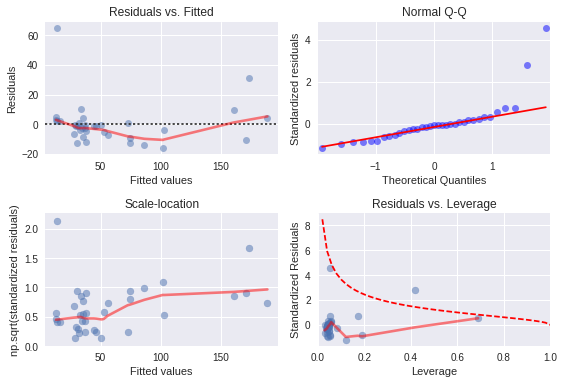

In [22]:
make_plots(data=data, y='Time', result=res)

## Continuing in diagnostics_in_multiple_linear_regression_part2.ipynb

## Other plots - not in the original notebook

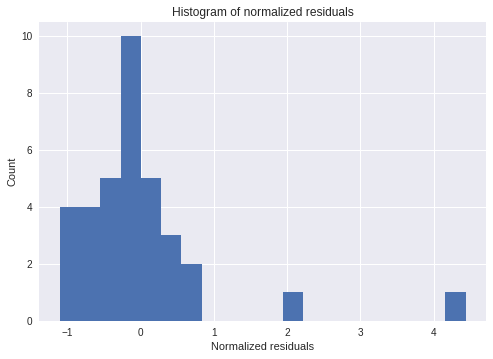

In [23]:
# other plots - histogram of errors after fitting
# Residuals, normalized to have unit variance.
plt.hist(res.resid_pearson, bins=20)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.title("Histogram of normalized residuals")
plt.show()

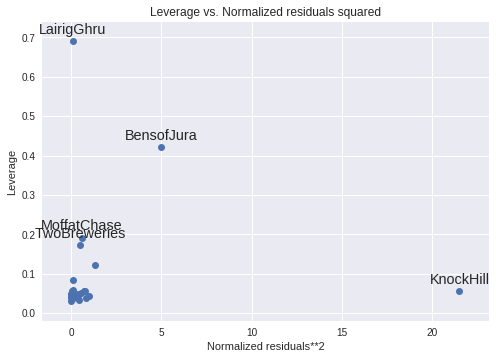

In [24]:
# other plots - Leverage vs. Normalized residual squared
# Observations with Large-standardized Residuals will be labeled in the plot.
# https://www.statsmodels.org/dev/generated/statsmodels.graphics.regressionplots.plot_leverage_resid2.html
sm.graphics.plot_leverage_resid2(res)
plt.show()

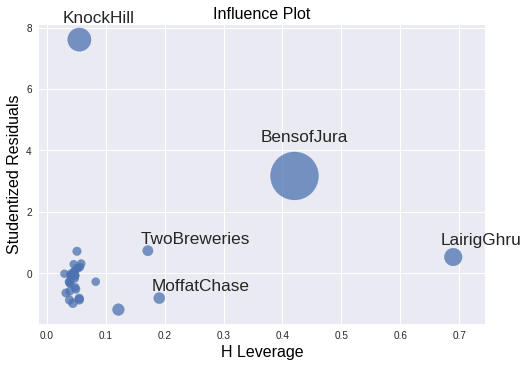

In [25]:
# other plots = influence plot
fig = sm.graphics.influence_plot(res, criterion="cooks")
plt.show()

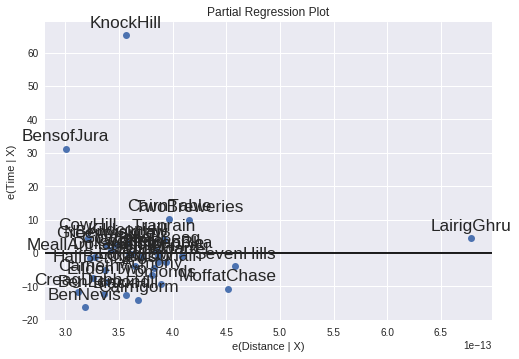

In [26]:
# other plots - Partial regression plots
fig = sm.graphics.plot_partregress("Time", "Distance", ["Distance", "Climb"], data=data)
plt.show()

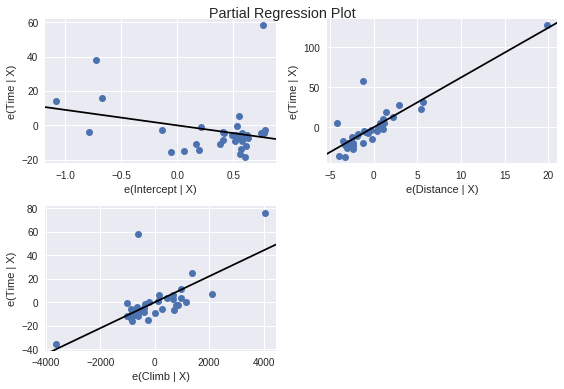

In [27]:
# other plots - Partial regression plot grid
fig = sm.graphics.plot_partregress_grid(res)
plt.show()

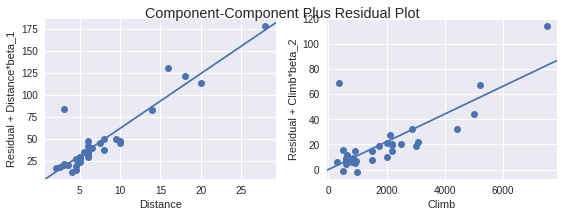

In [28]:
# other plots - CCPR(Component-Component plus Residual) grid
fig = sm.graphics.plot_ccpr_grid(res)
plt.show()

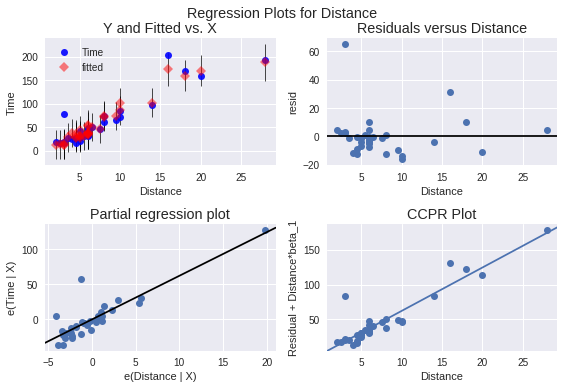

In [29]:
# other plots - handy quick check
fig = sm.graphics.plot_regress_exog(res, 'Distance')
plt.show()

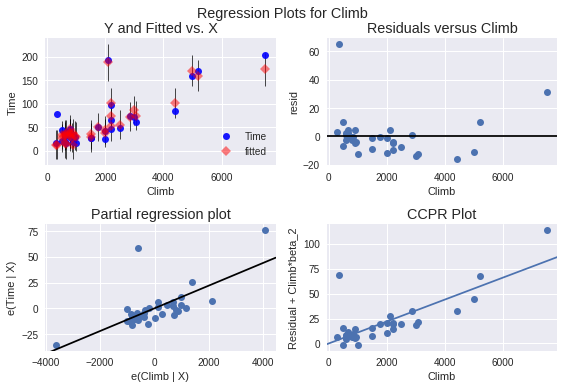

In [30]:
fig = sm.graphics.plot_regress_exog(res, 'Climb')
plt.show()

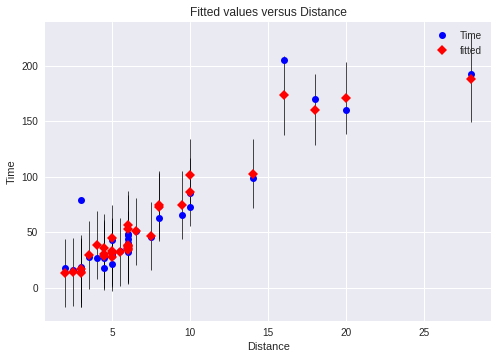

In [31]:
# other plots - fit plot
# includes prediction confidence intervals
fig = sm.graphics.plot_fit(res, "Distance")
plt.show()

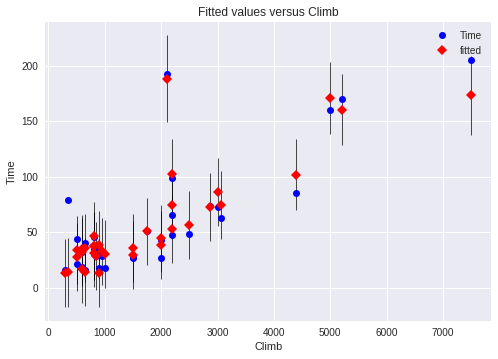

In [32]:
fig = sm.graphics.plot_fit(res, "Climb")
plt.show()

In [33]:
infl = res.get_influence()
infl.summary_frame()

,dfb_Intercept,dfb_Distance,dfb_Climb,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
Race,,,,,,,,,
Greenmantle,0.037811,-0.016614,-0.004744,0.000513,0.164547,0.053756,0.039219,0.162024,0.038618
Carnethy,-0.059580,0.067215,-0.073396,0.004875,-0.530157,0.049464,-0.120939,-0.524115,-0.119560
CraigDunain,-0.048577,-0.006707,0.028033,0.001365,-0.320258,0.038404,-0.064002,-0.315720,-0.063095
BenRha,-0.007665,-0.005675,0.008764,0.000064,-0.061540,0.048489,-0.013892,-0.060574,-0.013674
BenLomond,-0.050461,0.084709,-0.145005,0.014741,-0.869429,0.055271,-0.210295,-0.866026,-0.209472
Goatfell,0.003484,-0.004316,0.007576,0.000051,0.055980,0.046805,0.012405,0.055101,0.012210
BensofJura,-0.890655,-0.712774,2.364618,1.893349,2.798195,0.420435,2.383285,3.168980,2.699091
Cairnpapple,-0.008443,-0.001648,0.005562,0.000043,-0.054764,0.041033,-0.011328,-0.053904,-0.011150
Scolty,-0.014369,0.000913,0.006161,0.000095,-0.082497,0.040258,-0.016896,-0.081207,-0.016632


In [34]:
infl.cooks_distance

(array([5.12718454e-04, 4.87540113e-03, 1.36542189e-03, 6.43301018e-05,
        1.47413872e-02, 5.12926410e-05, 1.89334872e+00, 4.27756399e-05,
        9.51595016e-05, 1.40525458e-03, 2.10521354e-01, 9.61221178e-05,
        4.70383908e-03, 9.33944780e-03, 4.83428242e-03, 1.49074927e-02,
        2.38555867e-03, 4.07156045e-01, 1.02653923e-02, 4.17713466e-05,
        8.70005112e-04, 1.71615158e-04, 1.66116158e-03, 2.10787205e-03,
        4.98638596e-04, 1.31786537e-02, 5.11311574e-04, 1.01797846e-03,
        3.28957887e-06, 3.66935026e-03, 6.41225023e-02, 5.31189766e-04,
        3.76949064e-02, 5.29348945e-06, 5.24222273e-02]),
 array([0.99998359, 0.99952092, 0.99992875, 0.99999927, 0.99750547,
        0.99999948, 0.15057304, 0.9999996 , 0.99999869, 0.99992561,
        0.88836519, 0.99999867, 0.99954591, 0.99873536, 0.99952695,
        0.9974636 , 0.99983562, 0.74889062, 0.99854403, 0.99999962,
        0.99996374, 0.99999682, 0.99990442, 0.99986344, 0.99998426,
        0.99788819, 0.9999

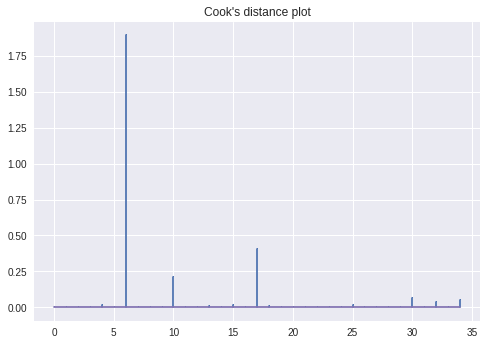

In [35]:
# c: distance
# p: p-value
(c, p) = infl.cooks_distance
plt.title("Cook's distance plot")
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.show()

In [36]:
# Variance inflation factor
# a measure for the increase of the variance of the parameter estimates 
# if an additional variable, given by exog_idx is added to the linear regression. 
# It is a measure for multicollinearity of the design matrix, exog.

# One recommendation is that if VIF is greater than 5, 
# then the explanatory variable given by exog_idx is highly collinear 
# with the other explanatory variables, and the parameter estimates 
# will have large standard errors because of this.
print(variance_inflation_factor(res.model.exog, exog_idx=0))
print(variance_inflation_factor(res.model.exog, exog_idx=1))
print(variance_inflation_factor(res.model.exog, exog_idx=2))

# Source: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

3.008639743794376
1.740811952436253
1.740811952436253


In [37]:
X = data[["Distance", "Climb"]]
X = sm.add_constant(X)

pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
          index=X.columns)

/home/doojung/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const       3.008640
Distance    1.740812
Climb       1.740812
dtype: float64